# Solving TAXI Environment using QTable

## Imports

In [2]:
# Full imports
import gym

# Aliased imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Partial Import
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from tqdm.notebook import tqdm, trange
from IPython.display import clear_output


/home/alex/anaconda3/envs/rlpaint/lib/python3.9/site-packages/keras/utils/image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/home/alex/anaconda3/envs/rlpaint/lib/python3.9/site-packages/keras/utils/image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/home/alex/anaconda3/envs/rlpaint/lib/python3.9/site-packages/keras/utils/image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
/home/alex/anaconda3/envs/rlpaint/lib/python3.9/site-packages/keras/utils/image_utils.py:39: DeprecationWarning: HAMMING is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.HAMMING instead.
  'hamming': pil_image.HAMMIN

## Bootstrap

In [3]:
# Remember to export to export "LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/"" if using linux
# Drop numa errors in term: "for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done"


# We have GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Make videos folder
# Install asciinema: "apt-get install asciinema"
%mkdir videos

/bin/bash: /home/alex/anaconda3/envs/rlpaint/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: cannot create directory ‘videos’: File exists


## Random Agent

In [5]:
# Def env
env = gym.make("Taxi-v3")
video_recorder = VideoRecorder(env, "./videos/random_agent.json", enabled=True)

# Init state
state = env.reset()

for i in range(50):
    # Record video
    video_recorder.capture_frame()

    # Sample a random action
    action = env.action_space.sample()

    # Step
    env.step(action)

# End taxi instance
env.close()

/home/alex/anaconda3/envs/rlpaint/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


![](./videos/random_agent.gif)

## QLearning

We have the a grid of 5x5, where the pick-up and drop-off locations might be {R, G, B, Y}. Since the client might be a passanger, we need to account with an additional state:
* States of the taxi position: $5\times5$
* States of the drop-off locations: $4$
* States of the pick-up/passenger: $4$ (R, G, B, Y) + $1$ (on taxi) 

Then we have $5\times5\times5\times(4+1)=500$ total states.

In [6]:
# Full info on the default implementation
help(env.unwrapped)

Help on TaxiEnv in module gym.envs.toy_text.taxi object:

class TaxiEnv(gym.core.Env)
 |  The Taxi Problem
 |  from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
 |  by Tom Dietterich
 |  
 |  ### Description
 |  There are four designated locations in the grid world indicated by R(ed),
 |  G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off
 |  at a random square and the passenger is at a random location. The taxi
 |  drives to the passenger's location, picks up the passenger, drives to the
 |  passenger's destination (another one of the four specified locations), and
 |  then drops off the passenger. Once the passenger is dropped off, the episode ends.
 |  
 |  Map:
 |  
 |      +---------+
 |      |R: | : :G|
 |      | : | : : |
 |      | : : : : |
 |      | | : | : |
 |      |Y| : |B: |
 |      +---------+
 |  
 |  ### Actions
 |  There are 6 discrete deterministic actions:
 |  - 0: move south
 |  - 1: move north
 |  - 2: mo

In [25]:
# Def hyperparams
alpha = 0.1
gamma = 0.7
epsilon = 0.05

# Modify rewards
class RewardPolicyWrapper(gym.Wrapper):
    def __init__(self, env: env):
        super().__init__(env)
        self.env = env
    
    # Override step update
    def step(self, action):
        # Get original output
        next_state, reward, done, info = self.env.step(action)

        # Get current state
        tx, ty, p, dst = list(self.env.decode(self.env.s))

        # Destinations 
        dst_dict = {0: (0, 0), 1: (0, 4), 2: (4, 0), 3: (4, 3)}

        # Define rewards
        r = -1

        # Drop off penalties
        if (action == 5):
            # No passenger
            if (p != 4): r = -10

            # No destination
            elif ((tx, ty) != dst_dict[dst]): r = -10

            # Passenger & correct destination
            else: r = 20


        # Pickup with passenger
        if (action == 4):
            # We already have a passenger
            if (p == 4): r = -10

            # Not at passenger location
            elif ((tx, ty) != dst_dict[p]): r = -10

            # Pickup at location
            else: r = 10


        return next_state, r, done, info

# Define new environment
#env = RewardPolicyWrapper(gym.make("Taxi-v3"))
env = gym.make("Taxi-v3")

# Init qtable
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Episode done flag --> Whenever we have a successful drop
done = False
q_mean = []
r_mean = []
p_cnt = []

for e in trange(10000):
    # Reset environment
    state = env.reset()
    done = False

    # Metrics
    p = 0
    r = []

    while not done:
        if np.random.uniform(0, 1) < epsilon:
            # Pick random action
            action = env.action_space.sample()
        else:
            # Pick optimal action
            action = np.argmax(q_table[state])

        # Perform action
        next_state, reward, done, info = env.step(action)

        # Update Q
        curr_Q = q_table[state, action]
        next_max_Q = np.max(q_table[next_state])
        q_table[state, action]  = (1 - alpha) * curr_Q + alpha * (reward + gamma * next_max_Q)

        # Update state
        state = next_state

        # Metrics
        if reward == -10: p += 1
        r += [reward]
    
    # Append metrics
    p_cnt += [[e, p]]
    q_mean += [[e, q_table[np.where(q_table != 0)].mean()]]
    r_mean += [[e, np.mean(r)]]

p_cnt = np.array(p_cnt)
q_mean = np.array(q_mean)
r_mean = np.array(r_mean)

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_70574/681480000.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


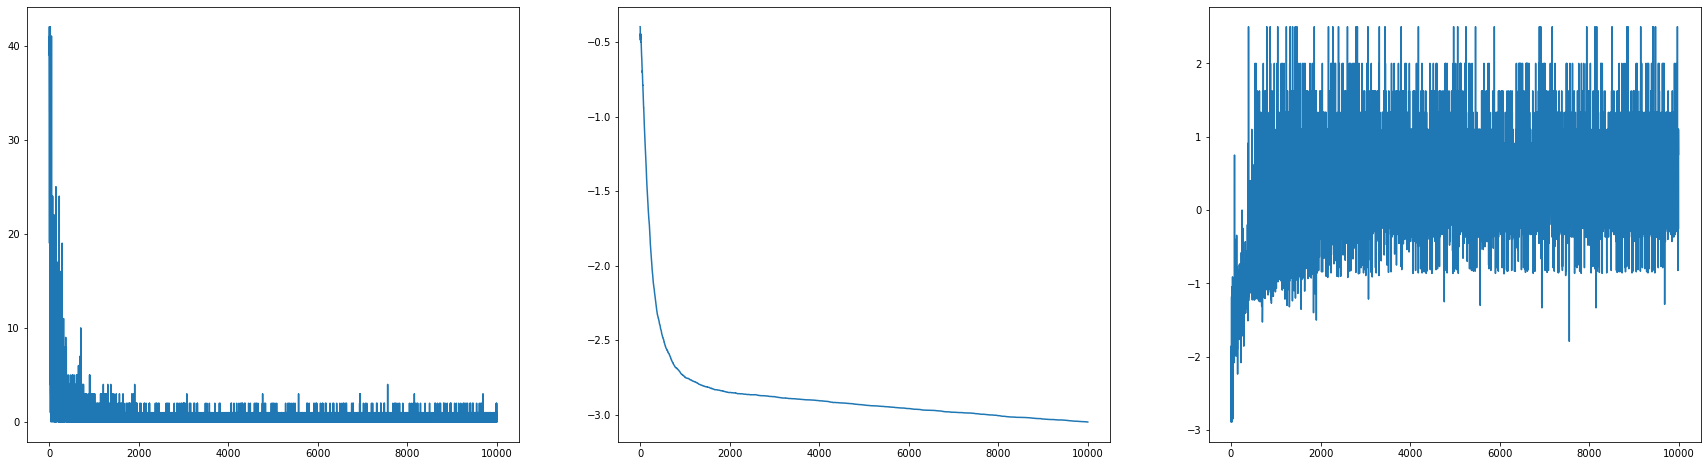

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
axs[0].plot(p_cnt[:, 0], p_cnt[:, 1])
axs[1].plot(q_mean[:, 0], q_mean[:, 1])
axs[2].plot(r_mean[:, 0], r_mean[:, 1])

fig.show()

In [31]:
# Def env
env = gym.make("Taxi-v3")
video_recorder = VideoRecorder(env, "./videos/q_agent.json", enabled=True)

# Init state
state = env.reset()

done = False
while not done:
    # Record video
    video_recorder.capture_frame()
    
    # Take optimal action
    action = np.argmax(q_table[state])

    # Step
    state, reward, done, info = env.step(action)

# End taxi instance
env.close()